In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [2]:
url = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/mlbootcamp5_train.csv'
data = pd.read_csv(url, sep=';')

data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Check if the target classes for cardiovascular dieases are balanced (have equal distribution).

In [3]:
data["cardio"].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

Target Classes for cholesterol are balanced.

In [4]:
cat_data = pd.melt(frame = data, 
                   value_vars = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
                   id_vars = ["cardio"])
cat_data.head()

,cardio,variable,value
0,0,gender,2
1,1,gender,1
2,1,gender,1
3,1,gender,2
4,0,gender,1


In [5]:
cat_data = pd.DataFrame(cat_data.groupby(["variable", "value", "cardio"])
                        ['value'].count()).rename(columns={'value': 'count'}).reset_index()
cat_data.head()

,variable,value,cardio,count
0,active,0,0,6378
1,active,0,1,7361
2,active,1,0,28643
3,active,1,1,27618
4,alco,0,0,33080


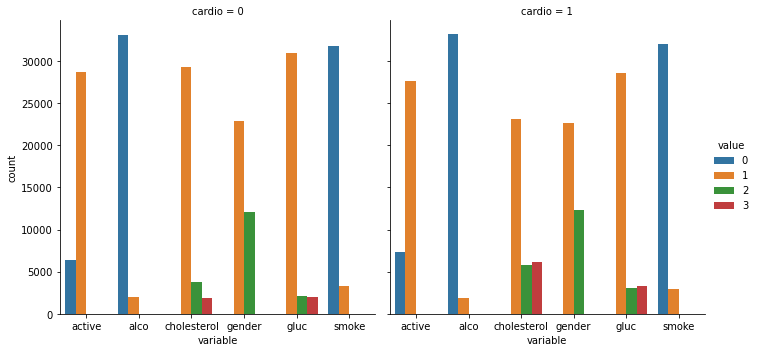

In [6]:
sns.catplot(x = "variable", y = "count", hue = "value", col = "cardio",
            data = cat_data, kind = "bar")

## Part 1. Preliminary data analysis

### 1.1. Basic observations
    
**Question 1.1**
How many men and women are present in this dataset? 
Values of the gender feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [7]:
data["gender"].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [8]:
print("Average height for gender 1:", round(data[data["gender"] == 1]["height"]
      .mean()))
print("Average height for gender 2:", round(data[data["gender"] == 2]["height"]
      .mean()))

Average height for gender 1: 161
Average height for gender 2: 170


1 is women, 2 is men
Ans: women: 45540, men: 24470 

**Question 1.2**
Which gender more often reports consuming alcohol - men or women?

In [9]:
print(data.groupby("gender")["alco"].value_counts(normalize = True))

gender  alco
1       0       0.974500
        1       0.025500
2       0       0.893625
        1       0.106375
Name: alco, dtype: float64


Men

**Question 1.3**
What is the difference between the percentages of smokers among men and women (rounded)?

In [10]:
data.groupby("gender")["smoke"].value_counts(normalize = True)

gender  smoke
1       0        0.982144
        1        0.017856
2       0        0.781120
        1        0.218880
Name: smoke, dtype: float64

About 20%

**Question 1.4**
What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of age in this dataset.

In [11]:
age_smoker = data[data["smoke"] == 1]["age"].median()
age_nonsmoker = data[data["smoke"] == 0]["age"].median()

display(age_smoker, age_nonsmoker)   # unit is in days

19125.0

19722.0

In [12]:
print('The age difference between smokers and nonsmokers are {} years.'.format(
    abs(round((age_smoker - age_nonsmoker)/30))))

The age difference between smokers and nonsmokers are 20 years.


### 1.2. Risk maps

**Question 1.5**
Calculate the fraction of the people with CVD for smoking men aged from 60 to 65 whose systolic pressure is less than 120 and cholesterol 
level is 4 mmol/L (1), and those with the pressure in the interval [160,180) and cholesterol level of 8 mmol/L (3). What is the ratio of these twofractions?

In [13]:
data["age_year"] = round(data["age"]/365.25)

data[(data["smoke"] == 1) & (data["gender"] == 2) & 
     (data["age_year"] >= 60) & (data["age_year"] < 65) & 
     (data["ap_hi"] < 120) & (data["cholesterol"] == 1)]["cardio"].\
     value_counts(normalize = True)                                   

0    0.736842
1    0.263158
Name: cardio, dtype: float64

In [14]:
data[(data["smoke"] == 1) & (data["gender"] == 2) & 
     (data["age_year"] >= 60) & (data["age_year"] < 65) & 
     (data["ap_hi"] >= 160) & (data["ap_hi"] < 180) & 
     (data["cholesterol"] == 3)]["cardio"].value_counts(normalize = True)

1    0.863636
0    0.136364
Name: cardio, dtype: float64

ratio = 3

### 1.3. Analyzing BMI

In [15]:
data["BMI"] = round(data["weight"] / (data["height"] / 100)**2, 1)

Choose the correct statements:
* Median BMI in the sample is within the range of normal BMI values.
* The BMI for women is on average higher than for men.
* Healthy people have, on average, a higher BMI than the people with CVD.
* For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [16]:
print(data["BMI"].median())

26.4


Median is outside normal BMI [18.5, 25]

In [17]:
data.groupby("gender")["BMI"].median()

gender
1    26.7
2    25.9
Name: BMI, dtype: float64

BMI for wome is higher than men on average.

In [18]:
data.groupby("cardio")["BMI"].median()

cardio
0    25.5
1    27.5
Name: BMI, dtype: float64

Healthy people with no cardiovascular diease have, on average, lower BMI (25.5) than ill people (27,5).

In [19]:
print("BMI for health, non-drinking men is {}.".format(data[(data["alco"] == 0) & (data["gender"] == 2) & (data["cardio"] == 0)]
      ["BMI"].median()))
print("BMI for health, non-drinking women is {}.".format(data[(data["alco"] == 0) & (data["gender"] == 1) & (data["cardio"] == 0)]
      ["BMI"].median()))

BMI for health, non-drinking men is 25.1.
BMI for health, non-drinking women is 25.7.


Average BMI for nondrinking health men and women are close.

### 1.4. Cleaning data

Filter out the following patient segments (we consider these as erroneous data)

* diastolic pressure is higher than systolic
* height is strictly less than 2.5 percentile 
* height is strictly more than 97.5 percentile
* weight is strictly less than 2.5 percentile
* weight is strictly more than 97.5 percentile

**Question 1.7** What percent of the original data (rounded) did we throw away?

In [20]:
init_rows = data.shape[0]

filtered_data = data[(data["ap_lo"] <= data["ap_hi"]) & 
                     (data["height"] >= data["height"].quantile(0.025)) & 
                     (data["height"] <= data["height"].quantile(0.975)) &
                     (data["weight"] >= data["weight"].quantile(0.025)) & 
                     (data["weight"] <= data["weight"].quantile(0.975))]
filtered_rows = filtered_data.shape[0]

(init_rows - filtered_rows)/init_rows

0.0963

## Part 2. Visual data analysis
### 2.1. Correlation matrix visualization
Use the initial dataset (non-filtered).

**Question 2.1** Which pair of features has the strongest Pearson's correlation with the gender feature? 

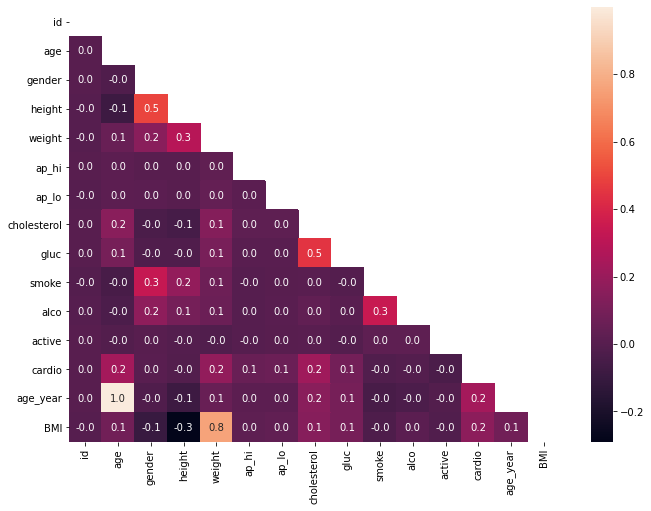

In [21]:
corr_mask = np.zeros_like(data.corr(), dtype = np.bool)
corr_mask[np.triu_indices_from(corr_mask)] = True

plt.figure(figsize=(11,8))
sns.heatmap(data.corr(), annot = True, fmt=".1f", mask = corr_mask)

Height and smoke

### 2.2. Height distribution of men and women
Task: Create a violin plot for the height and gender using violinplot().

In [22]:
height_dist = pd.melt(frame = data, value_vars = ["height"], 
                      id_vars = ["gender"])
height_dist

,gender,variable,value
0,2,height,168
1,1,height,156
2,1,height,165
3,2,height,169
4,1,height,156
...,...,...,...
69995,2,height,168
69996,1,height,158
69997,2,height,183
69998,1,height,163


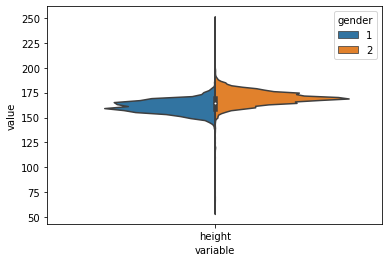

In [23]:
sns.violinplot(x = "variable", y = "value", hue = "gender",  split = True,
               data = height_dist)

Task: Create two kdeplots of the height feature for each gender on the same chart. 

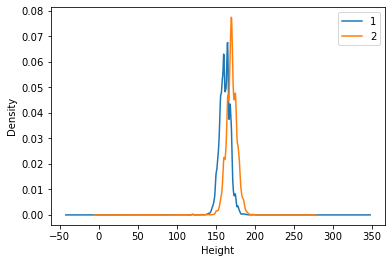

In [24]:
data.groupby("gender")["height"].plot.kde()
plt.xlabel("Height")
plt.legend()

**Question 2.2** Which pair of features has the strongest Spearman correlation?
* Height, Weight
* Age, Weight
* Cholesterol, Gluc
* Cardio, Cholesterol
* Ap_hi, Ap_lo
* Smoke, Alco

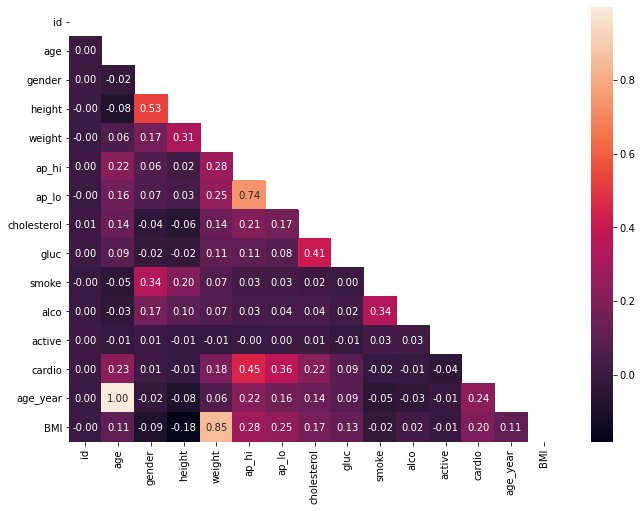

In [25]:
rank_mask = np.zeros_like(data.corr(method = "spearman"), dtype = np.bool)
rank_mask[np.triu_indices_from(rank_mask)] = True

plt.figure(figsize=(11,8))
sns.heatmap(data.corr(method = "spearman"), annot = True, fmt="0.2f", 
            mask = rank_mask)

ap_hi and ap_low

### 2.4. Age
Task: Create a count plot using countplot() with the age on the X axis and the number of people on the Y axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each cardio class of that age.

**Question 2.4** At what age does the number of people with CVD outnumber the number of people without CVD for the first time?

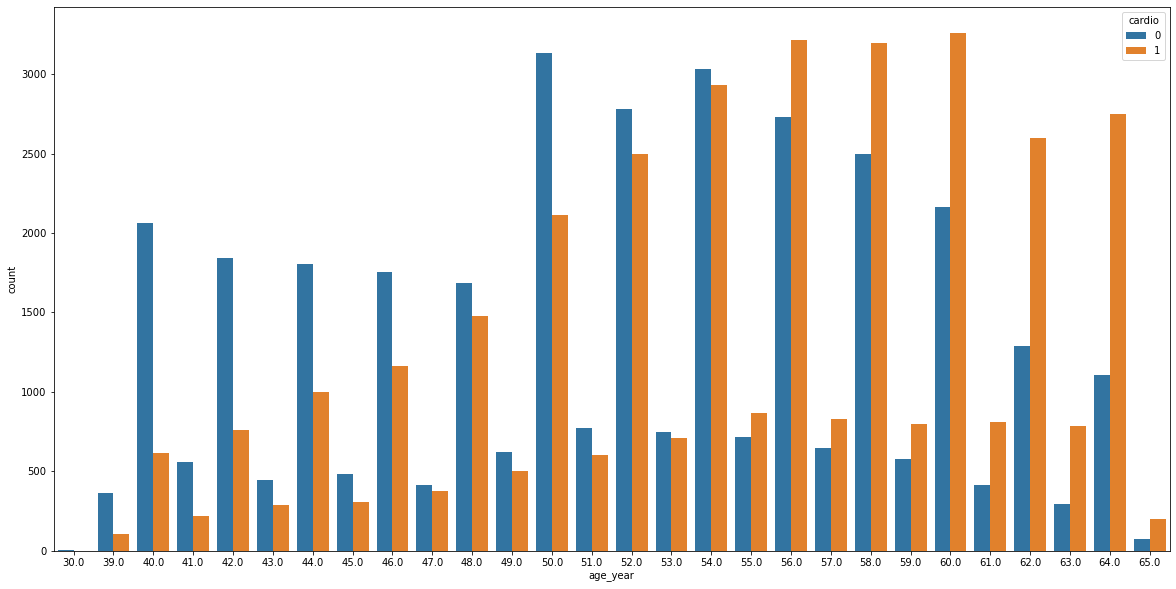

In [26]:
plt.figure(figsize=(20,10))
sns.countplot(x = "age_year", hue = "cardio", data = data)

Age 55